In [504]:
import pandas as panda
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
from somajo import SoMaJo
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [505]:
#Einlesen der Trainingsdaten Nummer 1

df = panda.read_csv("1234.csv", sep=";")

#df = df.replace("OTHER", "0")
#df = df.replace("OFFENSE", "1")

df.head()


,tweet,class1,classification
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1


In [506]:
# Hinzufügen der Spalte Text length und berechnen der Tweetlänge
df['text length'] = df['tweet'].apply(len)
print(df.head())

                                               tweet  class1  classification  \
0  @corinnamilborn Liebe Corinna, wir würden dich...     0.0               0   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...     0.0               0   
2  @ahrens_theo fröhlicher gruß aus der schönsten...     0.0               0   
3  @dushanwegner Amis hätten alles und jeden gewä...     0.0               0   
4  @spdde kein verläßlicher Verhandlungspartner. ...     1.0               1   

   text length  
0          109  
1          142  
2           69  
3          140  
4          136  


In [507]:
# anlegen der Variable "tweet"
tweet=df["tweet"]

In [508]:
#das Tokenisieren der Schimpfwortliste und Tweets
from somajo import SoMaJo
tokenizer = SoMaJo("de_CMC", split_camel_case=True)
schimpfwoerter = tokenizer.tokenize_text_file("schlist.txt", paragraph_separator="single_newlines")
schimpfwoerter2 = tokenizer.tokenize_text_file("Schimpfwortliste2.txt", paragraph_separator="single_newlines")

# Tokenisierung
def tokenize(text):
    textli = []
    for sentence in text:
        for token in sentence:
            y = token.text
            textli.append(y)
    return textli


# tokenisierte Schimpfwortliste
schlist = tokenize(schimpfwoerter)
schlist2 = tokenize(schimpfwoerter2)

In [509]:
#gesternte Worte finden
clean_tweet = df['tweet']
import re
exp = re.findall(r"[A-Za-z]+[*][*]+", str(clean_tweet), re.MULTILINE)
zensiert = re.findall(r"[*]+[A-Za-z]+[*]+", str(clean_tweet), re.MULTILINE)


#Zählen der zensierten Wörter
target = []
for item in exp:
    target.append(item[0])
print(len(target))

#Länge vergleichen
for i in exp:
    laenge = len(i)
    anf_i = re.findall("^[a-zA-Z]+", i)
    wort = anf_i[0]
    anf_i_length = (len(anf_i[0]))

    for a in schlist2:
        length = len(a)
        if length == laenge:
            print("Das zensierte Wort" + " " + i + " " + "mit der Länge" + " " + str(laenge) + " " + "ähnelt dem/den Schimpfwort/-wörtern" + " " + a + " " + "mit der Länge" + " " + " " + str(length))
            anf_schlist = a[0:anf_i_length]

            if str(wort) == str(anf_schlist):
                print(str(i) + " könnte das Wort " + str(a) + " sein.")

0


In [510]:
# Großgeschriebene Wörter finden
gross = re.findall(r"\s[A-Z][A-Z]+", str(tweet))
#Hashtags suchen
hashtags = re.findall(r"#[A-Za-z]+", str(tweet))


# Wörter in groß und schlist klein schreiben
schlist_lower = [every_string.lower() for every_string in schlist2]
gross_lower = [every_string.lower() for every_string in gross]
hashtags_lower = [every_string.lower() for every_string in hashtags]


#große Wörter in Schimpfwortliste finden
#Problem: vergleich auch einzelne Buchstaben
def caps(tweet):
    for line in tweet:
        for lines in gross_lower:
            if line in lines:
                print("Dieses Wort ist offensive:", line)

print(caps(schlist_lower))

#Alle Hashtags in der Schimpfwortliste finden
def ht(tweet):
    for line in tweet:
        for lines in hashtags_lower:
            if line in lines:
                print("Dieses Wort ist offensive:", line)
print(ht(schlist_lower))

None
None


In [502]:
## PREPROCESSING

#nltk.download('stopwords')
#Implementation der deutschen Stoppwortliste via NLTK
""""stopwords = nltk.corpus.stopwords.words("german")

#Erweitern der Liste
other_exclusions = ["rt", "ff", "#ff", "aber", "alle", "allem", "allen", "aller", "alles", "als", "also", "am", "an", "ander", "andere", "anderem", "anderen", "anderer", "anderes", "anderm", "andern", "anderr", 
                  "anders", "auch", "auf", 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 
                  'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies',
                  'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges',
                  'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin',
                  'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euch', 'im', 'in', 'indem', 'ins', 'ist', 'jede', 'jedem', 'jeden', 'jeder', 'jedes', 'jene', 'jenem',
                  'jenen', 'jener', 'jenes', 'jetzt', 'kann', 'kein', 'keine', 'keinem', 'keinen', 'keiner', 'keines', 'können', 'könnte', 'machen', 'man', 'manche', 'manchem', 'manchen', 'mancher', 
                  'manches', 'mein', 'meine', 'meinem', 'meinen', 'meiner', 'meines', 'mit', 'muss', 'musste', 'nach', 'nicht', 'nichts', 'noch', 'nun', 'nur', 'ob', 'oder', 'ohne', 'sehr', 'sein', 
                  'seine', 'seinem', 'seinen', 'seiner', 'seines', 'selbst', 'sich', 'sie', 'ihnen', 'sind', 'so', 'solche', 'solchem', 'solchen', 'solcher', 'solches', 'soll', 'sollte', 'sondern',
                  'sonst', 'über', 'um', 'und', 'uns', 'unsere', 'unserem', 'unseren', 'unser', 'unseres', 'unter', 'viel', 'vom', 'von', 'vor', 'während', 'war', 'waren', 'warst', 'was', 'weg', 'weil',
                  'weiter', 'welche', 'welchem', 'welchen', 'welcher', 'welches', 'wenn', 'werde', 'werden', 'wie', 'wieder', 'will', 'wir', 'wird', 'wirst', 'wo', 'wollen', 'wollte', 'würde', 'würden',
                  'zu', 'zum', 'zur', 'zwar', 'zwischen', "ja", "mehr", "warum", "wäre", "geht", "mal", "wer", "macht","lbr"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()"""

## 1. Entfernen von Satzzeichen, Sonderzeichen und lowercase transformation
def preprocess(tweet):  
    
    # entfernen von Extra Leerzeichen
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # Entfernen von Usernames @'s
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # Entfernen von URLS
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # Entfernen von Satzzeichen
    punc_remove = tweets.str.replace(r'[^\w\s]', " ")
    # Entfernen von Leerzeichen
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # Entfernen von Leerzeichen am Anfang des Tweets/Ende
    space_remove=newtweet.str.replace(r'^\s+|\s+?$','')
    # Ersetzen von Nummern mit "numbr"
    #nmbr_remove = space_remove.str.replace(r'\d+(\.\d+)?','numbr')
    # Entfernen von Großschreibung
    tweet_lower = space_remove.str.lower()
    
## 2: Tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

#Festlegen der Variable processed_tweets zum einfacheren Workflow
clean_tweet = preprocess(tweet)   

df['clean_tweet'] = preprocess(tweet)
#Ausgabe der Preprocess Ergebnisse
print(df[["tweet","clean_tweet"]].head(10))

                                               tweet  \
0  @corinnamilborn Liebe Corinna, wir würden dich...   
1  @Martin28a Sie haben ja auch Recht. Unser Twee...   
2  @ahrens_theo fröhlicher gruß aus der schönsten...   
3  @dushanwegner Amis hätten alles und jeden gewä...   
4  @spdde kein verläßlicher Verhandlungspartner. ...   
5  @Dirki_M Ja, aber wo widersprechen die Zahlen ...   
6  @milenahanm 33 bis 45 habe ich noch gar nicht ...   
7  @jayxderxmensch @jayxthexhuman Wieso? Was find...   
8  @tagesschau Euere AfD Hetze wirkt. Da könnt ih...   
9  Deutsche Medien, Halbwahrheiten und einseitige...   

                                         clean_tweet  
0  liebe corinna wir würden dich gerne als modera...  
1  sie haben ja auch recht unser tweet war etwas ...  
2  fröhlicher gruß aus der schönsten stadt der we...  
3  amis hätten alles und jeden gewählt nur hillar...  
4  kein verläßlicher verhandlungspartner nachkart...  
5  ja aber wo widersprechen die zahlen denn denen... 

In [503]:
#Finding words with # attached to it
df['#'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

frame = df['#']
frame.head()
type(frame)

pandas.core.series.Series

In [461]:
frame = panda.DataFrame(frame)
frame = frame.rename({'#':'Count(#)'},axis = 'columns')

frame[frame['Count(#)'] == ''] = 'No hashtags'
data_frame = panda.concat([df,frame],axis = 1)
data_frame.head(10)

,tweet,class1,classification,text length,clean_tweet,#,Count(#)
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,liebe corinna wir würden dich gerne als modera...,,No hashtags
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,sie haben ja auch recht unser tweet war etwas ...,,No hashtags
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß aus der schönsten stadt der we...,,No hashtags
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,amis hätten alles und jeden gewählt nur hillar...,,No hashtags
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,kein verläßlicher verhandlungspartner nachkart...,,No hashtags
5,"@Dirki_M Ja, aber wo widersprechen die Zahlen ...",0.0,0,255,ja aber wo widersprechen die zahlen denn denen...,,No hashtags
6,@milenahanm 33 bis 45 habe ich noch gar nicht ...,1.0,1,178,33 bis 45 habe ich noch gar nicht gelebt und e...,,No hashtags
7,@jayxderxmensch @jayxthexhuman Wieso? Was find...,0.0,0,63,wieso was findest du da unklar,,No hashtags
8,@tagesschau Euere AfD Hetze wirkt. Da könnt ih...,1.0,1,77,euere afd hetze wirkt da könnt ihr stolz sein ...,,No hashtags
9,"Deutsche Medien, Halbwahrheiten und einseitige...",1.0,1,133,deutsche medien halbwahrheiten und einseitige ...,,No hashtags


In [462]:
data_frame.drop('#',axis = 1,inplace = True)
data_frame.head(10)

,tweet,class1,classification,text length,clean_tweet,Count(#)
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,liebe corinna wir würden dich gerne als modera...,No hashtags
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,sie haben ja auch recht unser tweet war etwas ...,No hashtags
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß aus der schönsten stadt der we...,No hashtags
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,amis hätten alles und jeden gewählt nur hillar...,No hashtags
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,kein verläßlicher verhandlungspartner nachkart...,No hashtags
5,"@Dirki_M Ja, aber wo widersprechen die Zahlen ...",0.0,0,255,ja aber wo widersprechen die zahlen denn denen...,No hashtags
6,@milenahanm 33 bis 45 habe ich noch gar nicht ...,1.0,1,178,33 bis 45 habe ich noch gar nicht gelebt und e...,No hashtags
7,@jayxderxmensch @jayxthexhuman Wieso? Was find...,0.0,0,63,wieso was findest du da unklar,No hashtags
8,@tagesschau Euere AfD Hetze wirkt. Da könnt ih...,1.0,1,77,euere afd hetze wirkt da könnt ihr stolz sein ...,No hashtags
9,"Deutsche Medien, Halbwahrheiten und einseitige...",1.0,1,133,deutsche medien halbwahrheiten und einseitige ...,No hashtags


In [463]:
#Column showing whether the corresponding tweet has a hash tagged word or not
data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')
data_frame.head()

,tweet,class1,classification,text length,clean_tweet,Hash words
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,liebe corinna wir würden dich gerne als modera...,No hashtags
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,sie haben ja auch recht unser tweet war etwas ...,No hashtags
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß aus der schönsten stadt der we...,No hashtags
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,amis hätten alles und jeden gewählt nur hillar...,No hashtags
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,kein verläßlicher verhandlungspartner nachkart...,No hashtags


In [464]:
#Removing stopwords
stopwords = nltk.corpus.stopwords.words("german")
#Erweitern der Liste
other_exclusions = ["rt", "ff", "#ff", "aber", "alle", "allem", "allen", "aller", "alles", "als", "also", "am", "an", "ander", "andere", "anderem", "anderen", "anderer", "anderes", "anderm", "andern", "anderr", 
                  "anders", "auch", "auf", 'aus', 'bei', 'bin', 'bis', 'bist', 'da', 'damit', 'dann', 'der', 'den', 'des', 'dem', 'die', 'das', 'dass', 'daß', 'derselbe', 'derselben', 'denselben', 
                  'desselben', 'demselben', 'dieselbe', 'dieselben', 'dasselbe', 'dazu', 'dein', 'deine', 'deinem', 'deinen', 'deiner', 'deines', 'denn', 'derer', 'dessen', 'dich', 'dir', 'du', 'dies',
                  'diese', 'diesem', 'diesen', 'dieser', 'dieses', 'doch', 'dort', 'durch', 'ein', 'eine', 'einem', 'einen', 'einer', 'eines', 'einig', 'einige', 'einigem', 'einigen', 'einiger', 'einiges',
                  'einmal', 'er', 'ihn', 'ihm', 'es', 'etwas', 'euer', 'eure', 'eurem', 'euren', 'eurer', 'eures', 'für', 'gegen', 'gewesen', 'hab', 'habe', 'haben', 'hat', 'hatte', 'hatten', 'hier', 'hin',
                  'hinter', 'ich', 'mich', 'mir', 'ihr', 'ihre', 'ihrem', 'ihren', 'ihrer', 'ihres', 'euch', 'im', 'in', 'indem', 'ins', 'ist', 'jede', 'jedem', 'jeden', 'jeder', 'jedes', 'jene', 'jenem',
                  'jenen', 'jener', 'jenes', 'jetzt', 'kann', 'kein', 'keine', 'keinem', 'keinen', 'keiner', 'keines', 'können', 'könnte', 'machen', 'man', 'manche', 'manchem', 'manchen', 'mancher', 
                  'manches', 'mein', 'meine', 'meinem', 'meinen', 'meiner', 'meines', 'mit', 'muss', 'musste', 'nach', 'nicht', 'nichts', 'noch', 'nun', 'nur', 'ob', 'oder', 'ohne', 'sehr', 'sein', 
                  'seine', 'seinem', 'seinen', 'seiner', 'seines', 'selbst', 'sich', 'sie', 'ihnen', 'sind', 'so', 'solche', 'solchem', 'solchen', 'solcher', 'solches', 'soll', 'sollte', 'sondern',
                  'sonst', 'über', 'um', 'und', 'uns', 'unsere', 'unserem', 'unseren', 'unser', 'unseres', 'unter', 'viel', 'vom', 'von', 'vor', 'während', 'war', 'waren', 'warst', 'was', 'weg', 'weil',
                  'weiter', 'welche', 'welchem', 'welchen', 'welcher', 'welches', 'wenn', 'werde', 'werden', 'wie', 'wieder', 'will', 'wir', 'wird', 'wirst', 'wo', 'wollen', 'wollte', 'würde', 'würden',
                  'zu', 'zum', 'zur', 'zwar', 'zwischen', "ja", "mehr", "warum", "wäre", "geht", "mal", "wer", "macht","lbr"]
stopwords.extend(other_exclusions)
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords)]))
data_frame.head()

,tweet,class1,classification,text length,clean_tweet,Hash words
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,liebe corinna gerne moderatorin gewinnen wärst...,No hashtags
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,recht tweet missverständlich bverfg sachleistu...,No hashtags
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß schönsten stadt welt theo,No hashtags
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,amis hätten gewählt hillary wollten fortsetzun...,No hashtags
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,verläßlicher verhandlungspartner nachkarteln s...,No hashtags


In [465]:
#Stemming

ps = PorterStemmer()
adwait = data_frame
adwait.head()
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))
data_frame.head()


,tweet,class1,classification,text length,clean_tweet,Hash words
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0.0,0,109,lieb corinna gern moderatorin gewinnen wärst b...,No hashtags
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0.0,0,142,recht tweet missverständlich bverfg sachleistu...,No hashtags
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0.0,0,69,fröhlicher gruß schönsten stadt welt theo,No hashtags
3,@dushanwegner Amis hätten alles und jeden gewä...,0.0,0,140,ami hätten gewählt hillari wollten fortsetzung...,No hashtags
4,@spdde kein verläßlicher Verhandlungspartner. ...,1.0,1,136,verläßlich verhandlungspartn nachkarteln sondi...,No hashtags


In [466]:
import spacy
import de_core_news_lg


lemmatizer = spacy.load("de_core_news_lg")
#data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lemmatizer)

data_frame['clean_tweet'].head()

0    (lieb, corinna, gern, moderatorin, gewinnen, w...
1    (recht, tweet, missverständlich, bverfg, sachl...
2     (fröhlicher, gruß, schönsten, stadt, welt, theo)
3    (ami, hätten, gewählt, hillari, wollten, forts...
4    (verläßlich, verhandlungspartn, nachkarteln, s...
Name: clean_tweet, dtype: object

In [467]:
#nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

tagged_tweets = df['clean_tweet'].str.split().map(pos_tag)
tagged_tweets.head()

def count_tags(tagged_tweets1):
    tag_count = {}
    for word, tag in tagged_tweets1:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)
tagged_tweets.map(count_tags).head()

tagged_tweets = panda.DataFrame(tagged_tweets)
tagged_tweets['tag_counts'] = tagged_tweets['clean_tweet'].map(count_tags)
tagged_tweets.head()

,clean_tweet,tag_counts
0,"[(liebe, NN), (corinna, NN), (wir, VBZ), (würd...","{'NN': 5, 'VBZ': 2, 'JJ': 4, 'NNS': 1, 'VBP': ..."
1,"[(sie, NN), (haben, NN), (ja, NN), (auch, JJ),...","{'NN': 11, 'JJ': 5, 'NNS': 1, 'VBP': 1}"
2,"[(fröhlicher, RB), (gruß, JJ), (aus, NN), (der...","{'RB': 1, 'JJ': 2, 'NN': 4, 'VBD': 2}"
3,"[(amis, RB), (hätten, JJ), (alles, NNS), (und,...","{'RB': 1, 'JJ': 6, 'NNS': 1, 'IN': 1, 'NN': 10..."
4,"[(kein, NN), (verläßlicher, NN), (verhandlungs...","{'NN': 10, 'JJ': 2, 'VBZ': 1, 'IN': 1}"


<AxesSubplot:title={'center':'Frequency of POS Tags'}>

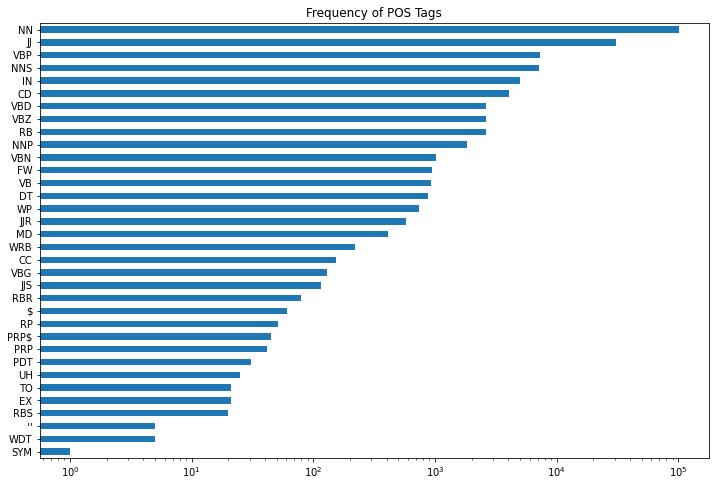

In [468]:
#POS Frequency

tag_set = list(set([tag for tags in tagged_tweets['tag_counts'] for tag in tags]))
for tag in tag_set:
    tagged_tweets[tag] = tagged_tweets['tag_counts'].map(lambda x: x.get(tag, 0))
title = 'Frequency of POS Tags'    
tagged_tweets[tag_set].sum().sort_values().plot(kind='barh', logx=True, figsize=(12,8), title=title)

In [469]:
vocabulary = {}
for row in tagged_tweets['clean_tweet']:
    for word, tag in row:
        if word in vocabulary:
            if tag in vocabulary[word]:
                vocabulary[word][tag] += 1
            else:
                vocabulary[word][tag] = 1
        else:
            vocabulary[word] = {tag: 1}
vocabulary_df = panda.DataFrame.from_dict(vocabulary, orient='index')
vocabulary_df.fillna(value=0, inplace=True)
tag = 'VBD' # NNP: Proper noun, singular 
vocabulary_df.sort_values(by=tag, ascending=False).head(20) # top 10 words for a given tag

,NN,JJ,RB,VBP,VBZ,VB,VBD,WP,WRB,IN,...,WDT,JJS,'',RBS,TO,EX,VBG,SYM,PRP,UH
was,0.0,0.0,0.0,0.0,0.0,0.0,774.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lbr,1823.0,497.0,4.0,81.0,175.0,3.0,71.0,0.0,0.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
welt,35.0,1.0,1.0,0.0,0.0,0.0,65.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gerade,83.0,8.0,0.0,2.0,0.0,0.0,40.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sich,143.0,755.0,0.0,13.0,25.0,6.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kann,288.0,22.0,0.0,28.0,35.0,12.0,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
geld,41.0,8.0,0.0,1.0,0.0,0.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sed,0.0,1.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mich,106.0,135.0,0.0,0.0,10.0,2.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
sollten,13.0,31.0,0.0,11.0,4.0,0.0,19.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Top 25 Most Frequent Words for NN Tag'}>

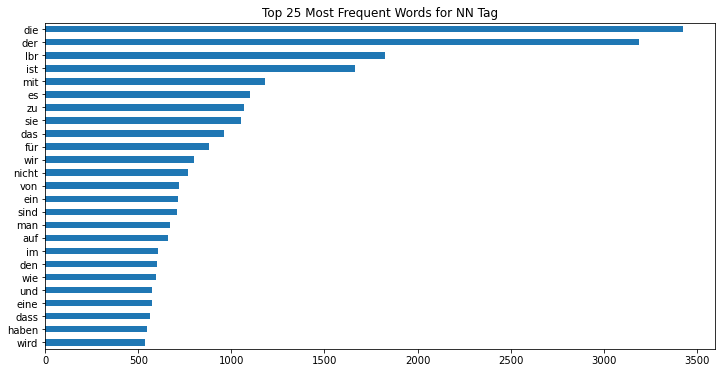

In [470]:
size = 25
tag = 'NN' # VBG: Verb, gerund or present participle
title = 'Top {} Most Frequent Words for {} Tag'.format(size, tag)
vocabulary_df[tag].sort_values().tail(size).plot(kind='barh', figsize=(12,6), title=title)

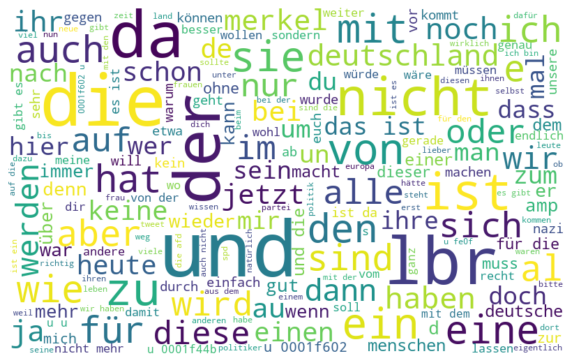

In [471]:
# WordCloud aller Tweets
from wordcloud import WordCloud
all_words = ' '.join([text for text in df['clean_tweet'] ]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

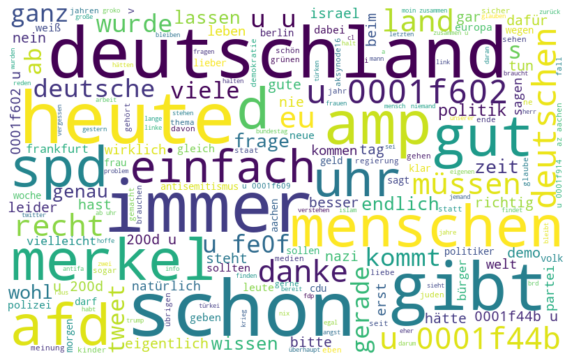

In [472]:
# WordCLoud für die Wörter der Klassifikation "OTHER"
hatred_words = ' '.join([text for text in df['clean_tweet'][df['classification'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110, stopwords=stopwords, background_color="white").generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

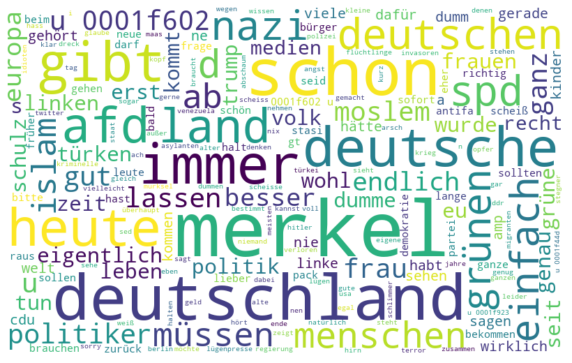

In [473]:
# WordCLoud für die Wörter der Klassifikation "OFFENSIVE"
offensive_words = ' '.join([text for text in df['clean_tweet'][df['classification'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110, stopwords=stopwords, background_color="white").generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [474]:
#TF-IDF Features-F1
# Unigrams & Bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.9, min_df=6, max_features=10000)

# TF-IDF feature matrix erstellen
tfidf = tfidf_vectorizer.fit_transform(df['clean_tweet'] )
tfidf

<9004x5350 sparse matrix of type '<class 'numpy.float64'>'
	with 158663 stored elements in Compressed Sparse Row format>

In [475]:
#Logistic Regression Modell
# Spezifizieren von "random_state", weil der Code sonst bei jedem Run eine neue Nummer generiert und man dann in train und test ständig neue Ergebnisse bekommt 
X = tfidf
y = df['classification'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)


              precision    recall  f1-score   support

           0       0.78      0.94      0.85       620
           1       0.76      0.40      0.53       281

    accuracy                           0.77       901
   macro avg       0.77      0.67      0.69       901
weighted avg       0.77      0.77      0.75       901

Logistic Regression, Accuracy Score: 0.7746947835738068


In [476]:
#Random Forest Modell
#selbiges mit Random_State
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       620
           1       0.75      0.30      0.43       281

    accuracy                           0.75       901
   macro avg       0.75      0.63      0.64       901
weighted avg       0.75      0.75      0.71       901

Random Forest, Accuracy Score: 0.7502774694783574


In [477]:
#Naive Bayes Modell
#selbiges mit Random_State
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.1)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.84      0.45      0.59       620
           1       0.40      0.81      0.54       281

    accuracy                           0.56       901
   macro avg       0.62      0.63      0.56       901
weighted avg       0.70      0.56      0.57       901

Naive Bayes, Accuracy Score: 0.562708102108768


In [478]:
#Support Vektor Maschine
support =LinearSVC(random_state=42)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       620
           1       0.62      0.57      0.59       281

    accuracy                           0.75       901
   macro avg       0.71      0.70      0.71       901
weighted avg       0.75      0.75      0.75       901

SVM, Accuracy Score: 0.7547169811320755


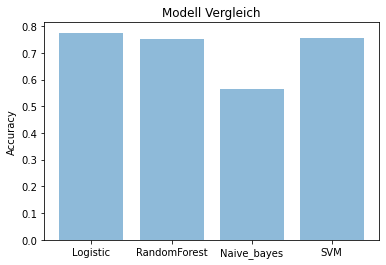

In [479]:
# Vergleich der accuracy der 4 Modelle
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Modell Vergleich')
plt.show()

In [480]:
## STARTEN DER SENTIMENT ANALYSE
#nltk.download('vader_lexicon')
sentiment_analyzer = VS()
#Auszählen der Tags und bewerten nach Klassifizierung
def count_tags(tweet_c): 
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

# definieren von 3 Segemnten 
def sentiment_analysis(clean_tweet):   
    sentiment = sentiment_analyzer.polarity_scores(clean_tweet)    
    twitter_objs = count_tags(clean_tweet)
    features = [sentiment['neg'], sentiment['neu'], sentiment['compound'], twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(clean_tweet):
    features=[]
    for t in clean_tweet:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(clean_tweet)
#final_features

# Negativ = vorkommen vom geparsten Text in OFFENSIVE, Neutral = vorkommen vom Geparsten Text in OTHER 
new_features = panda.DataFrame({'Neg':final_features[:,0],'Neutral':final_features[:,1],'Compound':final_features[:,2],
                            'url_tag':final_features[:,3],'mention_tag':final_features[:,4],'hash_tag':final_features[:,5]})
new_features

,Neg,Neutral,Compound,url_tag,mention_tag,hash_tag
0,0.000,1.000,0.0000,0.0,0.0,0.0
1,0.187,0.813,-0.5994,0.0,0.0,0.0
2,0.000,1.000,0.0000,0.0,0.0,0.0
3,0.000,1.000,0.0000,0.0,0.0,0.0
4,0.231,0.769,-0.5994,0.0,0.0,0.0
...,...,...,...,...,...,...
8999,0.000,0.924,0.1027,0.0,0.0,0.0
9000,0.000,1.000,0.0000,0.0,0.0,0.0
9001,0.162,0.664,0.0772,0.0,0.0,0.0
9002,0.000,1.000,0.0000,0.0,0.0,0.0


In [481]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(9004, 5356)

In [482]:
# Logistic Regression mit extracted Features

X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression,Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       620
           1       0.74      0.40      0.52       281

    accuracy                           0.77       901
   macro avg       0.76      0.67      0.68       901
weighted avg       0.76      0.77      0.74       901

Logistic Regression,Accuracy Score: 0.7680355160932297


In [483]:
# Random FOrest Modell mit extracted features
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       620
           1       0.78      0.28      0.41       281

    accuracy                           0.75       901
   macro avg       0.76      0.62      0.63       901
weighted avg       0.76      0.75      0.71       901

Random Forest, Accuracy Score: 0.7502774694783574


In [484]:
# Naive Bayes Modell mit extracted features
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_preds = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.84      0.48      0.61       620
           1       0.41      0.80      0.54       281

    accuracy                           0.58       901
   macro avg       0.63      0.64      0.58       901
weighted avg       0.71      0.58      0.59       901

Naive Bayes, Accuracy Score: 0.5782463928967814


In [485]:
# Support Vector Maschine mit extracted features
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.1)
support =LinearSVC(random_state=69)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       610
           1       0.66      0.55      0.60       291

    accuracy                           0.76       901
   macro avg       0.73      0.71      0.71       901
weighted avg       0.75      0.76      0.76       901

SVM, Accuracy Score: 0.7613762486126526


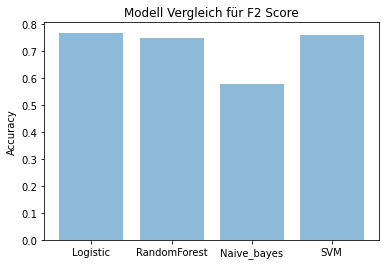

In [486]:
# Vergleich der 4 Modelle auf F2
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Modell Vergleich für F2 Score')
plt.show()

In [487]:
# Generieren von doc2vec
# Initialisieren & trainieren des Modells

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Input für doc2vec ist: (['list','of','word'], [TAG_001]). 
#Benutzung der Index der Sätze als Tags
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["clean_tweet"].apply(lambda x: x.split(" ")))]

# trainieren des Modells mit unseren Daten
# window- maximale Distanz zwischen aktuellem und predicted Wort innerhalb eines Satzes
# mincount- ignoriert alle Wörter mit einer absoluten Frequenz, die niedriger als die festgelegte ist
# workers - ANzahl der "worker threads" die das Modell trainieren
#  Training Model - distributed bag of words (PV-DBOW) wird verwendet
model = Doc2Vec(documents, vector_size=5, window=10, min_count=1, workers=5)

#infer_vector - Schlussfolgern von Vektoren basierend auf dem trainings Dokument 
# Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
# doc_words- Dokument für welches die Vektor Repräsentation geschlussfolgert wird

# alle Dokumente in Vektoren transformieren
doc2vec_df = df["clean_tweet"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.054004,-0.064483,-0.163081,-0.155742,0.011695
1,0.094482,0.010139,-0.060637,-0.161604,-0.027656
2,0.059856,0.085440,-0.071424,-0.099837,-0.068397
3,-0.070643,-0.090926,-0.006960,-0.040816,-0.002929
4,-0.038042,0.084790,-0.137679,0.014373,-0.024496
...,...,...,...,...,...
8999,-0.036407,-0.014773,-0.021939,-0.079113,-0.048191
9000,0.019791,0.007294,-0.257685,-0.313429,-0.014263
9001,-0.119627,-0.030153,-0.282454,-0.275178,-0.152129
9002,-0.061752,-0.085649,-0.228714,-0.196434,0.021087


In [488]:
# Verketten der TF-IDF Scores mit den doc2vex Ergebnissen
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(9004, 5361)

In [489]:
# Logistic Regression Modell mit TFIDF, sentiment Analyse & doc2vec
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       620
           1       0.75      0.40      0.52       281

    accuracy                           0.77       901
   macro avg       0.76      0.67      0.69       901
weighted avg       0.77      0.77      0.75       901

Logistic Regression, Accuracy Score: 0.7724750277469479


In [490]:
# Random Forest Modell mit TFIDF, sentiment Analyse & doc2vec
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.74      0.96      0.84       620
           1       0.76      0.25      0.38       281

    accuracy                           0.74       901
   macro avg       0.75      0.61      0.61       901
weighted avg       0.74      0.74      0.69       901

Random Forest, Accuracy Score: 0.7413984461709212


In [491]:
# Naive Bayes Modell mit TFIDF, sentiment Analyse & doc2vec
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.84      0.48      0.61       620
           1       0.41      0.80      0.54       281

    accuracy                           0.58       901
   macro avg       0.63      0.64      0.58       901
weighted avg       0.71      0.58      0.59       901

Naive Bayes, Accuracy Score: 0.5782463928967814


In [492]:
#Support Vector Maschine mit TFIDF, sentiment Analyse & doc2vec
X = panda.DataFrame(modelling_features)
y = df['classification'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.1)
support =LinearSVC(random_state=42)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       610
           1       0.64      0.55      0.59       291

    accuracy                           0.75       901
   macro avg       0.72      0.70      0.71       901
weighted avg       0.75      0.75      0.75       901

SVM, Accuracy Score: 0.753607103218646


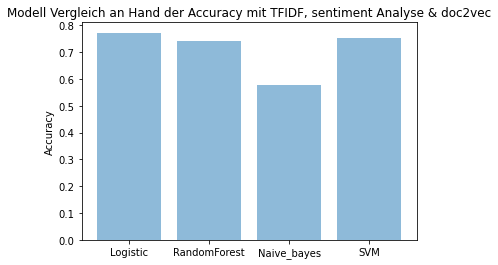

In [493]:
# Vergleich der 4 Modelle
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Modell Vergleich an Hand der Accuracy mit TFIDF, sentiment Analyse & doc2vec')
plt.show()